# Elevation Covariate

Read elevation data by a bounding box tile for stacking with other covariates in analysis.
Initial version uses SRTM v3 available as Cloud Optimized Geotiffs in MAAP.


1. Get bbox of tile
2. Buffer/extend bbox at min 1 pixel (can be more, no prob)3
3. Read the elev data
    1. save in /tmp
4. Clip and write_band for elev
5. Compute the 3 covars in memory with for loop; for covar in covars: calc, clip, write_band
    1. use GDAL DEMProcessing or gdaldem via python os.subprocess.run()


In [4]:
#only run this block if needed in a new workspace
%conda install -yq -c conda-forge rasterio geopandas folium

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [5]:
import sys
import json
import os
from pprint import pprint

import rasterio as rio
import geopandas as gpd
import shapely as shp
import folium
from shapely.geometry import box
from fiona.crs import from_epsg
from rasterio.mask import mask
from rasterio.warp import *
from rasterio.merge import merge
from rasterio import windows
import numpy as np
import matplotlib.pyplot as plt

from maap.maap import MAAP
maap = MAAP()


### 1. Get the bbox of the tile

In [46]:
# Get bbox extent
geojson_path = '/projects/maap-users/alexdevseed/boreal_tiles_latlong.geojson'
bbox_ID = 40349 #ID to match covar testing
#bbox_ID = 40311 #temp testing coastal

tile_index = gpd.read_file(geojson_path)
buffer = 0.001
in_geom_buffered = tile_index['geometry'].iloc[(bbox_ID-1)].buffer(buffer)
in_bbox = tile_index['geometry'].iloc[(bbox_ID-1)].bounds

print(in_bbox)

(-117.3, 50.6, -117.0, 50.9)


Use the bbox to find DEMs

In [47]:
# Read the copernicus index file
cop30dem_geojson = '/projects/maap-users/alexdevseed/dem30m_tiles.geojson'
cop30dem = gpd.read_file(cop30dem_geojson)

# intersect with the bbox tile
selection = cop30dem.loc[cop30dem.intersects(in_geom_buffered)]
selection.head()

,id,key,s3,geometry
5100,Copernicus_DSM_COG_10_N50_00_W118_00_DEM,Copernicus_DSM_COG_10_N50_00_W118_00_DEM/Coper...,s3://copernicus-dem-30m/Copernicus_DSM_COG_10_...,"POLYGON ((-118.00021 50.00014, -118.00021 51.0..."
5101,Copernicus_DSM_COG_10_N50_00_W117_00_DEM,Copernicus_DSM_COG_10_N50_00_W117_00_DEM/Coper...,s3://copernicus-dem-30m/Copernicus_DSM_COG_10_...,"POLYGON ((-117.00021 50.00014, -117.00021 51.0..."


### 2. Buffer/extend bbox

In [48]:
# Reformat bbox
#bbox_list =  [float(value) for value in converted_in_bbox.split(',')]
bbox_list = in_bbox
# Elevation covar calc will require consideration of tile edges. We want seemlessness across adjacent tiles
# To handle this, use this buffered bbox to extract elevation data, process it to the covars, then clip by original bbox
bbox_buffered = in_geom_buffered.bounds
# TODO: Probably need a 'bbox_buffered_list' from the above geometry...
print(bbox_buffered)

# Get centroid of bbox
#center = shp.geometry.box(*bbox_list).centroid
center = in_geom_buffered.centroid

m = folium.Map(
    # Zoom to center
    #location=[center.y,center.x],
    # Zoom to corner
    location=[bbox_list[1], bbox_list[2]],
    tiles="cartodbpositron",
    zoom_start=15,
)

bbox_style = {'fillColor': '#ff0000', 'color': '#ff0000'}
bbox_buf_style = {'fillColor': '#fdae61', 'color': '#fdae61'}

folium.GeoJson(selection, name="tiles").add_to(m)
folium.GeoJson(shp.geometry.box(*bbox_list), 
               name="bbox",
               style_function=lambda x:bbox_style).add_to(m)
folium.GeoJson(shp.geometry.box(*bbox_buffered), 
               name="bbox_buf",
               style_function=lambda x:bbox_buf_style).add_to(m)
m

(-117.301, 50.599000000000004, -116.999, 50.900999999999996)


### Read the elevation data (for the bbox)

For each result read the subwindow. After reading all the subwindows, merge them together as a single  array. 

In [18]:
import rasterio as rio
from rasterio.merge import merge
from rasterio.session import AWSSession 
from rasterio.plot import show
import boto3
from matplotlib.pyplot import imshow
import numpy as np
import numpy.ma as ma
from pyproj import Proj, Transformer

def hillshade(array,azimuth,angle_altitude):
    azimuth = 360.0 - azimuth 

    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth*np.pi/180.
    altituderad = angle_altitude*np.pi/180.

    shaded = np.sin(altituderad)*np.sin(slope) + np.cos(altituderad)*np.cos(slope)*np.cos((azimuthrad - np.pi/2.) - aspect)

    return 255*(shaded + 1)/2

def plot_band_array(band_array,refl_extent,title,cbar_label,colormap='spectral',alpha=1):
    plt.imshow(band_array,extent=refl_extent,alpha=alpha); 
    cbar = plt.colorbar(); plt.set_cmap(colormap); 
    cbar.set_label(cbar_label,rotation=270,labelpad=20)
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation #
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degree

In [39]:
# Set up and aws session
aws_session = AWSSession(boto3.Session())
# Get the s3 urls to the granules
file_s3 = selection["s3"].to_list()
file_s3.sort()
file_s3

['s3://copernicus-dem-30m/Copernicus_DSM_COG_10_N50_00_W129_00_DEM/Copernicus_DSM_COG_10_N50_00_W129_00_DEM.tif']

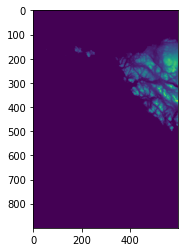

<AxesSubplot:>

In [40]:
# prove that we can read the aws files, an overview should be faster
# https://automating-gis-processes.github.io/CSC/notebooks/L5/read-cogs.html
with rio.Env(aws_session):
    with rio.open(file_s3[0], 'r') as src:
        # List of overviews from biggest to smallest
        oviews = src.overviews(1)

        # Retrieve the smallest thumbnail
        oview = oviews[1]
        thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

show(thumbnail)

In [43]:
# Create a mosaic from all the images
with rio.Env(aws_session):
    sources = [rio.open(raster) for raster in file_s3]

In [44]:
# Merge the source files
# TODO: test passing all s3 sources
mosaic, out_trans = merge(sources, bounds = bbox_list)

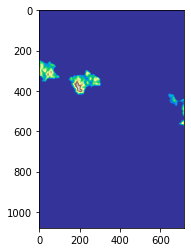

<AxesSubplot:>

In [45]:
# Mask the NoData values so it can be plotted correctly
# Since the DEM doesn't have nodata we need a Coastal/Water mask if we want to drop those pixels
#masked_mosaic = ma.masked_values(mosaic, int(sources[0].nodatavals[0]))
show(mosaic, cmap = 'terrain')

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 2400, 'height': 3600, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00041666666666666664, 0.0, -129.00020833333335,
       0.0, -0.0002777777777777778, 51.00013888888889), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}

### Write Results as Cloud Optimized Geotiff (Optional)
This step is included just to demonstrate writing the results to file for use in a later processing step.

In [ ]:
# Functions copied from 3.1.2
# TODO: create library of functions used acrosss notebooks
def define_raster(file, in_bbox, epsg="epsg:4326"):
    '''Read the first raster to get its transform and crs'''
    with rio.open(file, 'r') as f:
        bbox = transform_bounds(epsg, f.crs, *in_bbox)
        #w = windows.from_bounds(*bbox, transform=f.transform)
        #band = f.read(1, window=w, masked=True)
        band, out_transform = merge([f],bounds=bbox)
    return f.crs, out_transform
        
def MaskArrays(file, in_bbox, epsg="epsg:4326"):
    '''Read a window of data from the raster matching the tile bbox'''
    print(file)
    with rio.open(file, 'r') as f:
        bbox = transform_bounds(epsg, f.crs, *in_bbox)
        #w = windows.from_bounds(*bbox, transform=f.transform)
        #band = f.read(1, window=w, masked=True)
        band, out_transform = merge([f],bounds=bbox)
    return np.ma.masked_array(band[0].astype(float), mask=f.nodata)

def Write_to_disk(comp_stack, out_name):
    print("Writing to disk: {}".format(out_name))
    #TODO: full COG writing: higher compression, overviews, tile size, nodata
    kwargs=({'driver':'GTiff',
             'height':comp_stack.shape[0],
             'width':comp_stack.shape[1],
             'count':comp_stack.shape[2],
             'dtype':comp_stack.dtype,
             'crs':out_crs,
             'transform':out_transform,   #<--- TODO: should 'out_transform' be an input to this function?
             'compress':'deflate'
            })
    with rasterio.open(out_name, 'w', **kwargs) as dst:
        dst.write(np.moveaxis(comp_stack, [0, 1, 2], [2, 1, 0]))

In [ ]:
# TODO: format outname correctly to coincide with Landsat covars
data_path = "/projects/maap-users/username/"
tileid = "example"
ext = "_dem.tif"
dem_cog_fn = os.path.join(data_path, ".".join([tileid, ext]))
# TODO: 
#define_raster()
#Write_to_disk(masked_mosaic, dem_cog_fn)

### Derive topographic covariates from DEM
This step uses gdaldem to access the DEM COG, calc a topo covar, and write each covariate to a separate COG

In [ ]:
import os
# Format elev covar names
# example path

slope_cog_fn = "".join(os.path.splitext(dem_cog_fn)[0], '_slope.tif')
tpi_cog_fn   = "".join(os.path.splitext(dem_cog_fn)[0], '_tpi.tif')
tsri_cog_fn  = "".join(os.path.splitext(dem_cog_fn)[0], '_tsri.tif')

In [ ]:
from osgeo import gdal

def make_tsri(elevation, tsri_cog_fn):
    # TSRI
    # topo solar radiation index (a transformation of aspect; 0 - 1) TSRI = 0.5−cos((π/180)(aspect−30))/2
    # Matasci et al 2018: https://doi.org/10.1016/j.rse.2017.12.020
    # Use gdaldem API to handle tmp aspect calc in memory
    # Aspect is an intermediate step before calc'ing TSRI. Should we hold it in memory?
    print("Calculating Aspect from masked dem mosaic...")
    aspect = gdal.DEMProcessing('', elevation, 'aspect', format='MEM')

    tsri = 0.5 − np.cos((np.pi/180.)(aspect − 30.))/2.
    Write_to_disk(tsri, tsri_cog_fn)

make_tsri(masked_mosaic, tsri_cog_fn)

In [ ]:
## Paul - This assumes we've written the elevation to disk
# @Alex - is this more like what we'll want?
# TODO: all covar calcs will now be done in memory and written, band-by-band to a 'topo covars stack'
if dem_cog_fn.is_file():
    # Call gdaldem at cmd line to read in the elev file on disk
    # Slope
    # Use gdaldem command line tool to handle elev covar calcs
    # https://gdal.org/drivers/raster/cog.html
    # -compute_edges
    !gdaldem slope -of COG -zero_for_flat $dem_cog_fn $slope_cog_fn

    # TPI
    # topo position index (a measure of local concavity/convexity; -1 1) gdaldem TPI
    # -compute_edges
    !gdaldem tpi -of COG $dem_cog_fn $tpi_cog_fn
else:
    if hasattr(masked_mosaic, 'shape'): 
        print("Calculating Slope from masked dem mosaic...")
        slope = gdal.DEMProcessing('', elevation, 'slope', format='MEM')
        Write_to_disk(slope, slope_cog_fn)
        print("Calculating TPI from masked dem mosaic...")
        tpi = gdal.DEMProcessing('', elevation, 'tpi', format='MEM')
        Write_to_disk(tpi, tpi_cog_fn)
    else:
        print("Cannot calculate slope and TPI.\n{} is not written to disk and its array does not exist.".format(dem_cog_fn))